# 1. PostgreSQL database

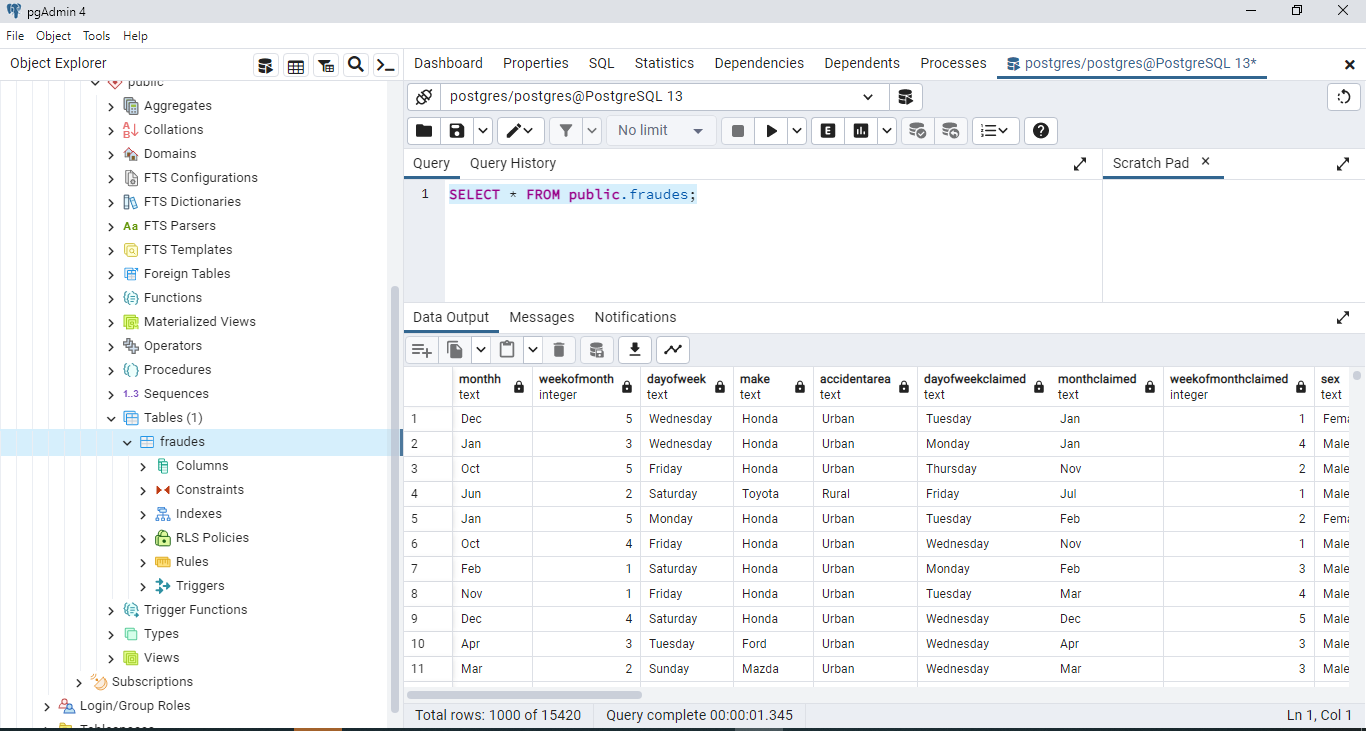

# 2. SQL Query

	WITH percentage_month AS (
	SELECT monthh, 
	COUNT(*) AS monthh_count, 
	SUM(fraudfound_p) AS monthh_sum
	FROM public.fraudes
	GROUP BY monthh
	),
	percentage_month_week AS (
	SELECT monthh, weekofmonth,
	COUNT(*) AS week_count, 
	SUM(fraudfound_p) AS week_sum
	FROM public.fraudes
	GROUP BY monthh, weekofmonth
	),
	percentage_month_day AS (SELECT monthh, weekofmonth, dayofweek,
    ROUND(SUM(fraudfound_p)*100.0 / COUNT(*), 2),
    COUNT(*) AS day_count, 
    SUM(fraudfound_p) AS day_sum
    FROM public.fraudes
    GROUP BY monthh, weekofmonth, dayofweek
        ORDER BY monthh, weekofmonth, dayofweek)
                    
     SELECT pm.monthh,
			ps.weekofmonth,
			pd.dayofweek,
			ROUND(pm.monthh_sum*100.0 / pm.monthh_count, 2) AS percentage_fraud_month,
			ROUND(ps.week_sum*100.0 / ps.week_count, 2) AS percentage_fraud_month_week,
			ROUND(pd.day_sum*100.0 / pd.day_count, 2) AS percentage_fraud_month_day
	FROM percentage_month_week ps 
	LEFT JOIN percentage_month pm ON pm.monthh = ps.monthh --AND ps.weekofmonth = pd.weekofmonth
	LEFT JOIN percentage_month_day pd ON pd.monthh = ps.monthh AND ps.weekofmonth = pd.weekofmonth
	GROUP BY pm.monthh,
			ps.weekofmonth,
			pd.dayofweek,
			percentage_fraud_month,
			percentage_fraud_month_week,
			percentage_fraud_month_day;

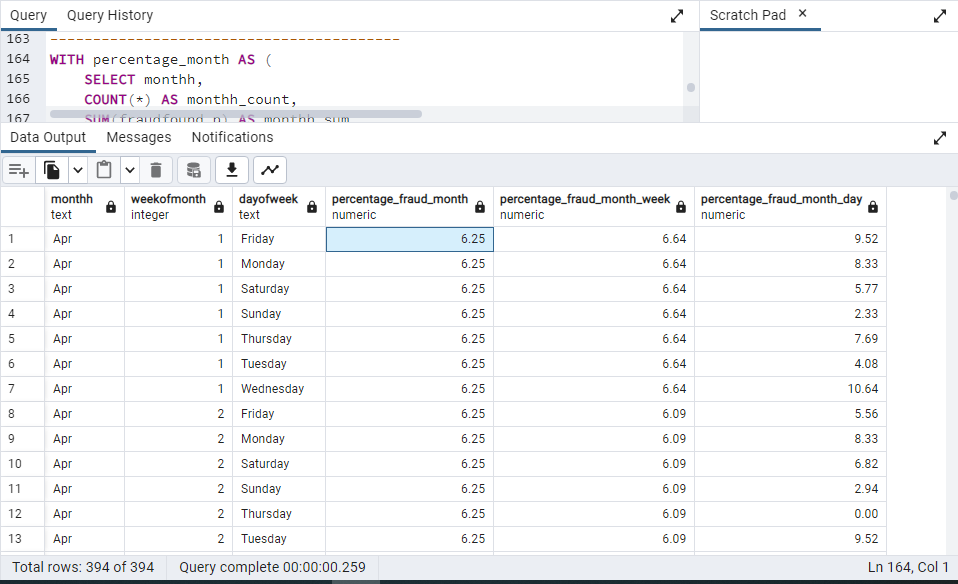

# 3. Connection to database

## Install requirements and import libraries

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
user='postgres'
password='12345'
host='localhost'
database='postgres'
port='5432'
    
url = f'postgresql://{user}:{password}@{host}:{port}/{database}'

engine = create_engine(url)

query = "SELECT * FROM public.fraudes"

fraud_data = pd.read_sql(query, engine)

engine.dispose()

# 4. Descriptive analysis and machine learning model

## Data cleaning

In [4]:
fraud_data.head()

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
for column in fraud_data.columns:
    print(f'\n{column}:\n{fraud_data[column].unique()}')


monthh:
['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']

weekofmonth:
[5 3 2 4 1]

dayofweek:
['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

make:
['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

accidentarea:
['Urban' 'Rural']

dayofweekclaimed:
['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']

monthclaimed:
['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']

weekofmonthclaimed:
[1 4 2 3 5]

sex:
['Female' 'Male']

maritalstatus:
['Single' 'Married' 'Widow' 'Divorced']

age:
[21 34 47 65 27 20 36  0 30 42 71 52 28 61 38 41 32 40 63 31 45 60 39 55
 35 44 72 29 37 59 49 50 26 48 64 33 74 23 25 56 16 68 18 51 22 53 46 43
 57 54 69 67 19 78 77 75 80 58 73 24 76 62 79 70 17 66]

fault:
['Policy Holder' 'Third Party']

policytype:
['Sport - Liability' 'Sport - Coll

A simple vista se encuentran dos campos con valores extraños, los cuales son: dayofweekclaimed y monthclaimed. Se investigan los registros que contengan estos valores:

In [6]:
fraud_data[fraud_data['dayofweekclaimed']=='0']

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
1519,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [7]:
fraud_data[fraud_data['monthclaimed']=='0']

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
1519,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


Los dos casos pertenecen al mismo registro. Se podría analizar si es prudente eliminar el registro (en caso de que no sea posible obtener la información real) para que no tenga efectos negativos en el análisis. Sin embargo, por ahora no se eliminará.

In [8]:
pd.isna(fraud_data)

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15416,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15417,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15418,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Se observa también que el campo policytype es la concatenación de vehiclecategory y de basepolicy, este campo podría ser información redundante y tener un impacto en el modelo por problemas de multicolinealidad. Otra observación es que el campo policynumber puede no ser muy relevante.

## EDA

### General Description

In [9]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   monthh                15420 non-null  object
 1   weekofmonth           15420 non-null  int64 
 2   dayofweek             15420 non-null  object
 3   make                  15420 non-null  object
 4   accidentarea          15420 non-null  object
 5   dayofweekclaimed      15420 non-null  object
 6   monthclaimed          15420 non-null  object
 7   weekofmonthclaimed    15420 non-null  int64 
 8   sex                   15420 non-null  object
 9   maritalstatus         15420 non-null  object
 10  age                   15420 non-null  int64 
 11  fault                 15420 non-null  object
 12  policytype            15420 non-null  object
 13  vehiclecategory       15420 non-null  object
 14  vehicleprice          15420 non-null  object
 15  fraudfound_p          15420 non-null

In [10]:
fraud_data.describe()

,weekofmonth,weekofmonthclaimed,age,fraudfound_p,policynumber,repnumber,deductible,driverrating,yearr
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


Se evidencia que en la edad mínima se encuentra el 0, lo cual no tiene mucho sentido y una posible explicación es que no se registró la edad en el momento en que se hizo la denuncia. Vemos la distribución de las edades:

### Age

<Axes: ylabel='Frequency'>

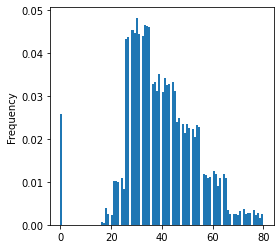

In [11]:
plt.rcParams["figure.figsize"] = (4, 4)
fraud_data['age'].plot(kind='hist', bins=100, density=True)

<Axes: >

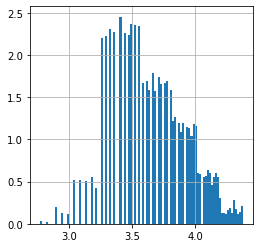

In [12]:
plt.rcParams["figure.figsize"] = (4, 4)
np.log(fraud_data[fraud_data['age']>0].age).hist(bins=100, density=True)

Estos casos donde la edad es cero se podrían tratar eliminando los datos (lo cual no es muy recomendable) o con aproximaciones como reemplazarlos por la media.

Otro análisis que podemos hacer es ver si la distribución de edades es diferente entre los casos donde hay fraude y los casos donde no, sin embargo, no se ven muy distintas:

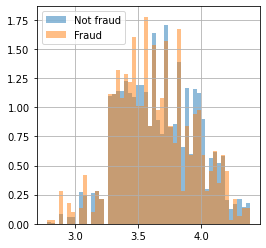

In [13]:
plt.rcParams["figure.figsize"] = (4, 4)
np.log(fraud_data[fraud_data['age']>0].age[fraud_data.fraudfound_p == 0]).hist(bins=50, density=True, alpha=0.5, label="Not fraud")
np.log(fraud_data[fraud_data['age']>0].age[fraud_data.fraudfound_p == 1]).hist(bins=50, density=True, alpha=0.5, label="Fraud")
plt.legend()

### Dependent variable

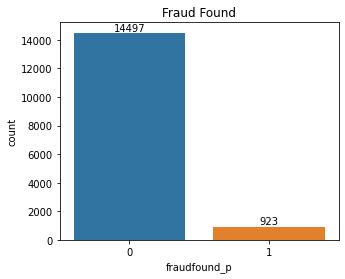

In [14]:
plt.rcParams["figure.figsize"] = (5, 4)
sns.countplot(x='fraudfound_p', data=fraud_data)
plt.title('Fraud Found')
_count = fraud_data['fraudfound_p'].value_counts().values.tolist()
_label = fraud_data['fraudfound_p'].value_counts().index.tolist()

for i, c in enumerate(_count):
    plt.annotate(str(c), xy=(i, c), ha='center', va='bottom')

plt.show()

### Price

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'less than 20000'),
  Text(1, 0, '20000 to 29000'),
  Text(2, 0, '30000 to 39000'),
  Text(3, 0, '40000 to 59000'),
  Text(4, 0, '60000 to 69000'),
  Text(5, 0, 'more than 69000')])

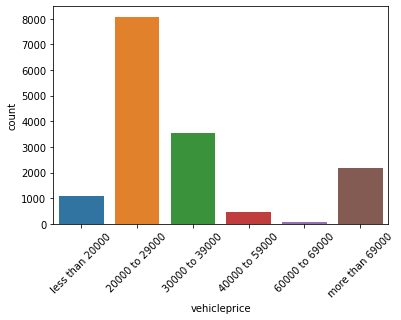

In [15]:
plt.rcParams["figure.figsize"] = (6, 4)
field = "vehicleprice"
price_order = ["less than 20000", "20000 to 29000", "30000 to 39000", "40000 to 59000", "60000 to 69000", "more than 69000"]
sns.countplot(x=field, data=fraud_data, order=price_order)
plt.xticks(rotation=45)

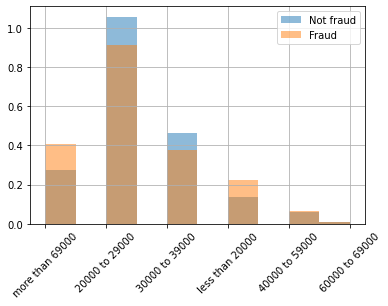

In [16]:
plt.rcParams["figure.figsize"] = (6, 4)
fraud_data['vehicleprice'][fraud_data.fraudfound_p == 0].hist(bins=10, density=True, alpha=0.5, label="Not fraud")
fraud_data['vehicleprice'][fraud_data.fraudfound_p == 1].hist(bins=10, density=True, alpha=0.5, label="Fraud")
plt.xticks(rotation = 45)
plt.legend()

### Sex

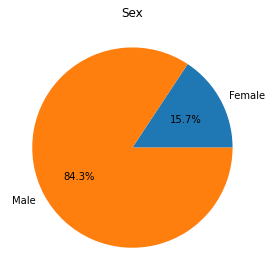

In [17]:
plt.rcParams["figure.figsize"] = (6, 4)
sex_claim_app = fraud_data.groupby('sex').count()['age']

fig, ax = plt.subplots()
ax.pie(sex_claim_app, labels=sex_claim_app.index, autopct='%.1f%%')
ax.set_title('Sex')

plt.tight_layout()
plt.show()

In [18]:
sex_rate = []
_sex = fraud_data['sex'].unique()

for sex in _sex:
    
    total = len(fraud_data[fraud_data['sex']==sex]['sex'])
    fraud = len(fraud_data[(fraud_data['fraudfound_p']==1) & (fraud_data['sex']==sex)]['sex'])
    
    sex_rate.append(fraud*100/total)
    print(f'Sexo {sex} - Núm. Reclamos: {total}, Núm. Fraude: {fraud}, Relación: {fraud*100/total:,.2f}%')

Sexo Female - Núm. Reclamos: 2420, Núm. Fraude: 105, Relación: 4.34%
Sexo Male - Núm. Reclamos: 13000, Núm. Fraude: 818, Relación: 6.29%


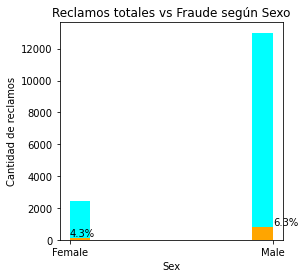

In [19]:
plt.rcParams["figure.figsize"] = (4, 4)
all_gender_serie = fraud_data['sex']
fraud_gender_serie = fraud_data[fraud_data['fraudfound_p']==1]['sex']
_sex = fraud_data['sex'].unique()

plt.hist(all_gender_serie, histtype='stepfilled', color="cyan", label="Total")
plt.xlabel("Sex")
plt.ylabel("Cantidad de reclamos")
plt.title("Reclamos totales vs Fraude según Sexo")

plt.rcParams["figure.figsize"] = (3, 4)
v,m,g = plt.hist(fraud_gender_serie, histtype='stepfilled', color="orange", label="Fraud")
_label = [_label for _label in v if _label !=0]

for x,y,valor in zip(_sex, _label, sex_rate):   
    plt.text(x,y+100,'%.1f'%valor+'%',fontsize=10,ha="left")
plt.show() 

###  Heatmap

<Axes: >

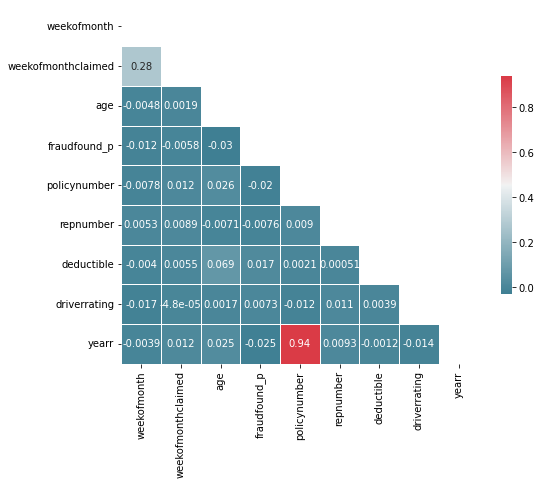

In [20]:
plt.rcParams["figure.figsize"] = (8, 8)
numeric_fraud_data = fraud_data.select_dtypes(include='number')

fraud_data_correlations = numeric_fraud_data.corr()

mask = np.zeros_like(fraud_data_correlations, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(fraud_data_correlations, annot=True, cmap=cmap, mask=mask,
            cbar_kws={"shrink": .5}, square=True, linewidths=.5)

No se evidencia ninguna correlación importante, excepto entre policynumber y yearr, lo cual tiene sentido ya que el número de registros aumenta en el tiempo. Se considera eliminar del modelo policynumber.

## Model

### Logistic regression model

Se prueba primero un modelo clásico de regresión logística, los resultados serán comparados con un modelo más complejo posteriormente. En este caso solo se tendrán en cuenta los campos numéricos

In [21]:
def fit_logistic_regression(X,y):
    return LogisticRegression(solver='saga', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial').fit(X,y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(numeric_fraud_data.drop(["fraudfound_p"], axis=1),#fraud_data[["deductible"]], 
                                                    fraud_data['fraudfound_p'], 
                                                    test_size=0.7, random_state=42)

logistic_model = fit_logistic_regression(X_train, y_train)
y_test_pred = logistic_model.predict_proba(X_test)[:,1]

C:\Users\Liso\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


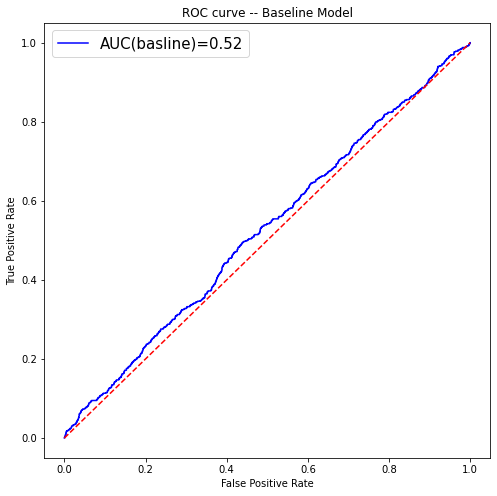

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc_baseline = auc(fpr, tpr)

plt.plot(fpr, tpr, "b-", label="AUC(basline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model");

### Encoding data

In [24]:
categorical_fraud_data = fraud_data.select_dtypes(include='object')
categorical_fraud_data.columns

Index(['monthh', 'dayofweek', 'make', 'accidentarea', 'dayofweekclaimed',
       'monthclaimed', 'sex', 'maritalstatus', 'fault', 'policytype',
       'vehiclecategory', 'vehicleprice', 'days_policy_accident',
       'days_policy_claim', 'pastnumberofclaims', 'ageofvehicle',
       'ageofpolicyholder', 'policereportfiled', 'witnesspresent', 'agenttype',
       'numberofsuppliments', 'addresschange_claim', 'numberofcars',
       'basepolicy'],
      dtype='object')

Es necesario convertir las variables categóricas nominales y ordinales a numéricas antes de agregarlas al modelo


#### Variables nominales
'make', 'accidentarea', 'sex', 'maritalstatus', 'fault', 'policytype', 'vehiclecategory', 'policereportfiled',
'witnesspresent', 'agenttype', 'basepolicy'

#### Variables ordinales
'monthh','dayofweek','dayofweekclaimed','monthclaimed','vehicleprice','days_policy_accident','days_policy_claim','pastnumberofclaims','ageofvehicle','ageofpolicyholder','numberofsuppliments','addresschange_claim', 'numberofcars'


Sin embargo, antes de convertir los datos, hay que limpiar los ceros que se encuentran en dayofweekclaimed y en monthclaimed. Por simplicidad se va a eliminar este registro.

In [25]:
_fraud_data = fraud_data.copy()

_fraud_data = _fraud_data[_fraud_data['dayofweekclaimed']!='0']

In [26]:
monthh_map = {
    0:0,
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12
}

dayofweek_map = {
    'Monday':1,
    'Tuesday':2,
    'Wednesday':3,
    'Thursday':4,
    'Friday':5,
    'Saturday':6,
    'Sunday':7 
}

dayofweekclaimed_map = {
    0:0,
    'Monday':1,
    'Tuesday':2,
    'Wednesday':3,
    'Thursday':4,
    'Friday':5,
    'Saturday':6,
    'Sunday':7 }

monthclaimed_map = {
    0:0,
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12
}

vehicleprice_map = {
    'less than 20000':1,
    '20000 to 29000':2,
    '30000 to 39000':3,
    '40000 to 59000':4,
    '60000 to 69000':5,
    'more than 69000':7  
  
}

days_policy_accident_map = {
    'none':0,
    '1 to 7':1,
    '8 to 15':2,
    '15 to 30':3,
    'more than 30':4
}


days_policy_claim_map = {
    'none':0,
    '8 to 15':1,
    '15 to 30':2,
    'more than 30':3
}

pastnumberofclaims_map = {
    'none':0,
    '1':1,
    '2 to 4':2,
    'more than 4':3
}

ageofvehicle_map = {
    'new':1,
    '2 years':2,
    '3 years':3,
    '4 years':4,
    '5 years':5,
    '6 years':6,
    '7 years':7,
    'more than 7':8
}

ageofpolicyholder_map = {
    '16 to 17':1,
    '18 to 20':2,
    '21 to 25':3,
    '26 to 30':4,
    '31 to 35':5,
    '36 to 40':6,
    '41 to 50':7,
    '51 to 65':8,
    'over 65':9 
}

numberofsuppliments_map = {
    'none':0,
    '1 to 2':1,
    '3 to 5':2,
    'more than 5':3
}

addresschange_claim_map = {
    'no change':0,
    'under 6 months':1,
    '1 year':2,
    '2 to 3 years':3,
    '4 to 8 years':4
}

numberofcars_map = {
    '1 vehicle':1,
    '2 vehicles':2,
    '3 to 4':3,
    '5 to 8':4,
    'more than 8':5
}

ordinal_fields = ['monthh','dayofweek','dayofweekclaimed','monthclaimed','vehicleprice','days_policy_accident',
                    'days_policy_claim','pastnumberofclaims','ageofvehicle','ageofpolicyholder','numberofsuppliments',
                    'addresschange_claim', 'numberofcars']

dictionary_map = [monthh_map, dayofweek_map, dayofweekclaimed_map, monthclaimed_map, vehicleprice_map,
days_policy_accident_map, days_policy_claim_map, pastnumberofclaims_map, ageofvehicle_map, ageofpolicyholder_map,
numberofsuppliments_map, addresschange_claim_map, numberofcars_map]

for field, mapping in zip(ordinal_fields, dictionary_map):
    _fraud_data[field] = _fraud_data[field].map(mapping)

In [27]:
nominal_fields = ['make', 'accidentarea', 'sex', 'maritalstatus', 'fault', 'policytype', 'vehiclecategory', 
                  'policereportfiled', 'witnesspresent', 'agenttype', 'basepolicy']

label_encoder = LabelEncoder()
for column in nominal_fields:
    _fraud_data[column] = label_encoder.fit_transform(_fraud_data[column])

In [28]:
_fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15419 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   monthh                15419 non-null  int64
 1   weekofmonth           15419 non-null  int64
 2   dayofweek             15419 non-null  int64
 3   make                  15419 non-null  int32
 4   accidentarea          15419 non-null  int32
 5   dayofweekclaimed      15419 non-null  int64
 6   monthclaimed          15419 non-null  int64
 7   weekofmonthclaimed    15419 non-null  int64
 8   sex                   15419 non-null  int32
 9   maritalstatus         15419 non-null  int32
 10  age                   15419 non-null  int64
 11  fault                 15419 non-null  int32
 12  policytype            15419 non-null  int32
 13  vehiclecategory       15419 non-null  int32
 14  vehicleprice          15419 non-null  int64
 15  fraudfound_p          15419 non-null  int64
 16  policynum

In [29]:
_fraud_data.isnull().sum()

monthh                  0
weekofmonth             0
dayofweek               0
make                    0
accidentarea            0
dayofweekclaimed        0
monthclaimed            0
weekofmonthclaimed      0
sex                     0
maritalstatus           0
age                     0
fault                   0
policytype              0
vehiclecategory         0
vehicleprice            0
fraudfound_p            0
policynumber            0
repnumber               0
deductible              0
driverrating            0
days_policy_accident    0
days_policy_claim       0
pastnumberofclaims      0
ageofvehicle            0
ageofpolicyholder       0
policereportfiled       0
witnesspresent          0
agenttype               0
numberofsuppliments     0
addresschange_claim     0
numberofcars            0
yearr                   0
basepolicy              0
dtype: int64

Se obtienen los datos de entrenamiento y de testeo. Se elimina la columna policynumber ya que no debería aportar nada al modelo

In [30]:


X_train, X_test, y_train, y_test = train_test_split(_fraud_data.drop(["fraudfound_p","policynumber"], axis=1),#fraud_data[["deductible"]], 
                                                    _fraud_data['fraudfound_p'], 
                                                    test_size=0.7, random_state=42)

logistic_model = fit_logistic_regression(X_train, y_train)
y_test_pred = logistic_model.predict_proba(X_test)[:,1]

C:\Users\Liso\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


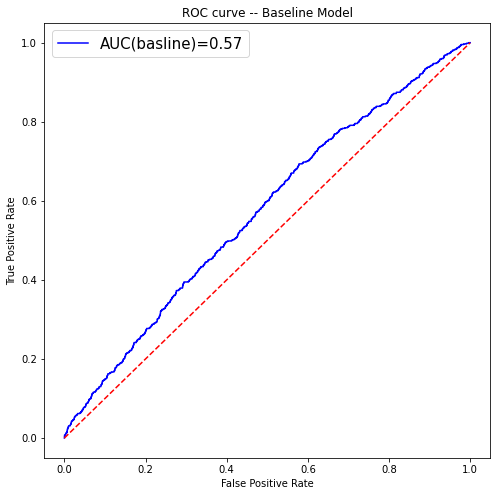

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc_baseline = auc(fpr, tpr)

plt.plot(fpr, tpr, "b-", label="AUC(basline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model");

### Decision tree

Una consideración importante al elaborar el árbol de decisión es que los datos de la variable dependiente no están balanceados ya que los registros donde hay fraude corresponden solo al 6% aproximadamente del total. Esto se puede arreglar con el parámetro class_weight.

In [32]:
model = DecisionTreeClassifier(class_weight={0:.1, 1:.9})

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.90550305725403


### Validación cruzada

In [33]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

X = _fraud_data.drop(["fraudfound_p","policynumber"], axis=1)
y = _fraud_data['fraudfound_p']

cv_scores = cross_val_score(model, X, y, cv=5) 

print("Precisión en cada fold:", cv_scores)
print("Precisión media:", cv_scores.mean())

Precisión en cada fold: [0.89461738 0.89818418 0.89526589 0.9001297  0.92020759]
Precisión media: 0.9016809473145273


In [34]:
feature_importances = model.feature_importances_

feature_names = X.columns.tolist()

feature_importances_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Imprimir las columnas con mayor relevancia
print("Columnas con mayor relevancia:")
for feature, importance in feature_importances_sorted:
    print(feature, ":", importance)

Columnas con mayor relevancia:
basepolicy : 0.1203879600201486
fault : 0.11313859773233359
age : 0.08824919277716081
make : 0.06532122094779053
deductible : 0.06353096967697174
weekofmonth : 0.06111213387069465
monthclaimed : 0.05000196965327481
monthh : 0.04970532065863711
dayofweek : 0.04755367953247603
repnumber : 0.0447091641756753
yearr : 0.04182979036003368
dayofweekclaimed : 0.027070256092549056
driverrating : 0.025481159317620884
ageofvehicle : 0.024487959371080215
weekofmonthclaimed : 0.022438459731520838
vehicleprice : 0.02119771928723124
pastnumberofclaims : 0.020744943223178606
accidentarea : 0.019744129555553273
numberofsuppliments : 0.016534405278573465
ageofpolicyholder : 0.015062959955779477
policytype : 0.014877820550649321
maritalstatus : 0.012731487007591878
sex : 0.007641166525873289
days_policy_claim : 0.007494539077197446
addresschange_claim : 0.006905163223852306
numberofcars : 0.0065139418177290855
policereportfiled : 0.0032911679147413853
days_policy_accident :

Antes de concluir, vemos de forma gráfica las variables que el modelo entregó como más relevantes

###  Base Policy

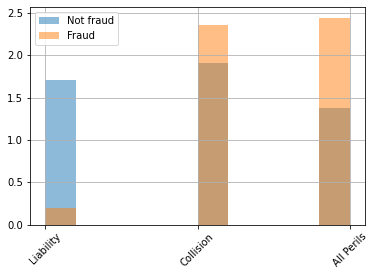

In [35]:
plt.rcParams["figure.figsize"] = (6, 4)
fraud_data['basepolicy'][fraud_data.fraudfound_p == 0].hist(bins=10, density=True, alpha=0.5, label="Not fraud")
fraud_data['basepolicy'][fraud_data.fraudfound_p == 1].hist(bins=10, density=True, alpha=0.5, label="Fraud")
plt.xticks(rotation = 45)
plt.legend()

###  Fault

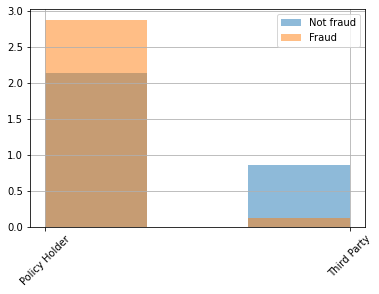

In [36]:
plt.rcParams["figure.figsize"] = (6, 4)
fraud_data['fault'][fraud_data.fraudfound_p == 0].hist(bins=3, density=True, alpha=0.5, label="Not fraud")
fraud_data['fault'][fraud_data.fraudfound_p == 1].hist(bins=3, density=True, alpha=0.5, label="Fraud")
plt.xticks(rotation = 45)
plt.legend()

### Make

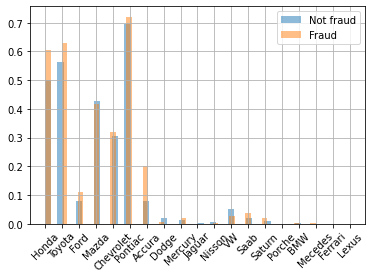

In [37]:
plt.rcParams["figure.figsize"] = (6, 4)
fraud_data['make'][fraud_data.fraudfound_p == 0].hist(bins=50, density=True, alpha=0.5, label="Not fraud")
fraud_data['make'][fraud_data.fraudfound_p == 1].hist(bins=50, density=True, alpha=0.5, label="Fraud")
plt.xticks(rotation = 45)
plt.legend()

### Deductible

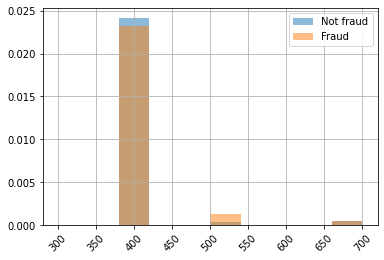

In [38]:
plt.rcParams["figure.figsize"] = (6, 4)
fraud_data['deductible'][fraud_data.fraudfound_p == 0].hist(bins=10, density=True, alpha=0.5, label="Not fraud")
fraud_data['deductible'][fraud_data.fraudfound_p == 1].hist(bins=10, density=True, alpha=0.5, label="Fraud")
plt.xticks(rotation = 45)
plt.legend()

# 5. Dashboard

El tablero se desarrolló en Power BI y se adjunta con el nombre de TABLERO R5.pibx

# 6. Conclusions

El modelo de árbol de decisión inicialmente mostró un rendimiento alto con una precisión de aproximadamente 0.903. Además, la validación cruzada proporcionó una precisión media de aproximadamente 0.902, lo que sugiere que el modelo generaliza bien y no muestra signos evidentes de sobreajuste.

Las características más importantes para el modelo incluyen basepolicy, fault, age, make, deductible, entre otras. Esto sugiere que a estas características se les debe prestar especial atención al crear estrategias para prevenir fraudes.

Con algunas características como basepolicy y fault, las herramientas gráficas nos pueden mostrar información valiosa ya que las distribuciones son muy diferentes entre los casos de fraude y no fraude. Con otras características como age y make esto no es tan evidente.

El modelo de regresión logística no funcionó muy bien con este conjunto de datos como se ve en la curva ROC.

Como trabajo futuro sería interesante implementar otros modelos como random forest y comparar resultados entre modelos.